# Smart ETF: Mimic SOXX with a Small Subset of Constituents

**Objective.** Build a feasible pipeline to approximate the performance of **SOXX (iShares Semiconductor ETF)** using a much smaller subset of its constituents (e.g., 3–10 names) with price-only data from free sources (e.g., `yfinance`).

**Constraints.**
- Data: Free OHLCV + corporate actions via `yfinance` (dividends/splits). Limited fundamentals may exist but are not guaranteed.
- Focus: U.S. markets, semiconductors (SOXX).

**Approach.**
1. Acquire SOXX + constituent prices (daily adjusted close).
2. Engineer market-based features (momentum, volatility, beta, liquidity proxies).
3. Calibrate a low-cardinality linear tracker (OLS/LASSO) → *Smart ETF weights*.
4. Evaluate tracking error, correlation, stability, and risk.
5. Communicate assumptions and caveats responsibly.

> **Delivery reminder:** This master notebook is structured in **12 stages**, each with clear markdown guidance and runnable code stubs.



## Table of Contents
1. [stage01 — problem-framing-and-scoping](#stage01)
2. [stage02 — tooling-setup & slides-outline](#stage02)
3. [stage03 — python-fundamentals](#stage03)
4. [stage04 — data-acquisition-and-ingestion](#stage04)
5. [stage05 — data-storage](#stage05)
6. [stage06 — data-preprocessing](#stage06)
7. [stage07 — outliers-risk-assumptions](#stage07)
8. [stage08 — exploratory-data-analysis (EDA)](#stage08)
9. [stage09 — feature-engineering](#stage09)
10. [stage10 — linear regression & time-series modelling](#stage10)
11. [stage11 — evaluation & risk communication](#stage11)


# stage01_problem-framing-and-scoping
<a id='stage01'></a>

**Goal.** Approximate **SOXX** daily performance using a **small subset of its holdings** via price-based features and linear models.  
**Primary KPIs.**
- **Correlation** between ETF and Smart ETF daily returns (↑).
- **R²** of regression (↑).
- **Tracking error** (annualized std of return differences) (↓).
- **Cumulative performance gap** over the backtest (≈ 0).

**Scope & Feasibility.**
- **In-scope:** SOXX + (top N) semis; daily Adj Close; 2015–present (tunable).
- **Out-of-scope (for now):** Full accounting data, transaction costs, taxes, intraday microstructure.

**Assumptions (declare explicitly):**
- Rebalance schedule (e.g., monthly/quarterly) is fixed and rule-based.
- Survivorship bias risk acknowledged; holdings list frozen to current top names for the backtest unless historical holdings are sourced explicitly.
- Dividends approximated via adjusted close; explicit dividend modeling omitted.

**Success Criteria.**
- Using ≤ 5–10 names achieves corr ≥ 0.9 and annualized tracking error ≤ 2–3% (targets are adjustable).


# stage02_tooling-setup_slides-outline
<a id='stage02'></a>

**Environment & Libraries.**
- Core: `python`, `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `statsmodels`, `yfinance`, `pyyaml`.





In [1]:
# install if running locally
!pip install yfinance pandas numpy matplotlib scikit-learn statsmodels pyyaml openpyxl

In [4]:
import os, sys, math, json, time, datetime as dt, warnings
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# paths
PROJECT_ROOT = os.getcwd()
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
FIG_DIR = os.path.join(PROJECT_ROOT, 'figures')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

np.random.seed(69)

print('Setup complete. Folders:', DATA_DIR, FIG_DIR)

Setup complete. Folders: /Users/paramshah/Desktop/Bootcamp/project/notebooks/data /Users/paramshah/Desktop/Bootcamp/project/notebooks/figures


# stage03_python-fundamentals
<a id='stage03'></a>

Small warmups to ensure consistent return math and vectorization patterns.


In [2]:
# Warmup: daily simple returns from prices
def simple_returns(prices: pd.Series) -> pd.Series:
    r = prices.pct_change()
    return r

def log_returns(prices: pd.Series) -> pd.Series:
    lr = np.log(prices).diff()
    return lr

# Example stub
_demo = pd.Series([100, 101, 98, 99, 102], index=pd.date_range('2020-01-01', periods=5, freq='D'))
print('Prices\n', _demo)
print('Simple returns\n', simple_returns(_demo))
print('Log returns\n', log_returns(_demo))

Prices
 2020-01-01    100
2020-01-02    101
2020-01-03     98
2020-01-04     99
2020-01-05    102
Freq: D, dtype: int64
Simple returns
 2020-01-01         NaN
2020-01-02    0.010000
2020-01-03   -0.029703
2020-01-04    0.010204
2020-01-05    0.030303
Freq: D, dtype: float64
Log returns
 2020-01-01         NaN
2020-01-02    0.009950
2020-01-03   -0.030153
2020-01-04    0.010152
2020-01-05    0.029853
Freq: D, dtype: float64


# stage04_data-acquisition-and-ingestion
<a id='stage04'></a>

We’ll pull **SOXX** and a curated subset of **semiconductor constituents** from `yfinance`.  
> Note: `yfinance` provides ETF prices directly. Holdings are not always programmatically available for free historically; we **parameterize** a curated list (top names) and store it in YAML/JSON for reproducibility.

**Chosen baseline tickers (adjust as needed):**
- ETF: `SOXX`
- Candidates (subset of semis): `NVDA, AVGO, TSM, AMD, INTC, QCOM, TXN, ASML, MU, ADI`

**Date range:** 2015-01-01 → today (configurable).


In [21]:
import yaml
import datetime as dt
import yfinance as yf

CONFIG = {
    'etf': 'SOXX',
    'candidates': ['NVDA','AVGO','TSM','AMD','INTC','QCOM','TXN','MRVL','MU','LRCX'],
    'start': '2015-01-01',
    'end': None,
    'price_field': 'Adj Close'
}

# save config for reproducibility
with open(os.path.join(DATA_DIR, 'config_soxx.yml'), 'w') as f:
    yaml.safe_dump(CONFIG, f)

# download price data
def fetch_prices(tickers, start, end=None, price_field='Adj Close') -> pd.DataFrame:
    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    # standardize shape of the ticker
    if isinstance(tickers, str) or (hasattr(tickers, '__len__') and not isinstance(tickers, str) and len(tickers) == 1):
        df = df[[price_field]].rename(columns={price_field: tickers if isinstance(tickers, str) else tickers[0]})
    else:
        df = df[price_field]
    return df

etf_prices = fetch_prices(CONFIG['etf'], CONFIG['start'], CONFIG['end'], CONFIG['price_field'])
stock_prices = fetch_prices(CONFIG['candidates'], CONFIG['start'], CONFIG['end'], CONFIG['price_field'])

print('ETF price shape:', etf_prices.shape)
print('Stocks price shape:', stock_prices.shape)

# Persist raw pulls
etf_prices.to_parquet(os.path.join(DATA_DIR, 'soxx_prices_raw.parquet'))
stock_prices.to_parquet(os.path.join(DATA_DIR, 'semi_prices_raw.parquet'))

ETF price shape: (2680, 1)
Stocks price shape: (2680, 10)


# stage05_data-storage
<a id='stage05'></a>

We store **raw** and **processed** tables separately and maintain a **data dictionary** (YAML).  
- Raw: `data/*_raw.parquet`
- Processed: `data/*_proc.parquet`
- Metadata: `data/datadict.yml`


In [22]:
datadict = {
    'tables': {
        'soxx_prices_raw': {'path': 'data/soxx_prices_raw.parquet', 'keys': ['date'], 'description': 'Daily Adj Close for SOXX'},
        'semi_prices_raw': {'path': 'data/semi_prices_raw.parquet', 'keys': ['date','ticker'], 'description': 'Daily Adj Close for selected semiconductor stocks'}
    },
    'notes': 'All prices pulled via yfinance; adjusted close used for return calculations.'
}
with open(os.path.join(DATA_DIR, 'datadict.yml'), 'w') as f:
    yaml.safe_dump(datadict, f)

print('Wrote data dictionary to', os.path.join(DATA_DIR, 'datadict.yml'))

Wrote data dictionary to /Users/paramshah/Desktop/Bootcamp/project/notebooks/data/datadict.yml


# stage06_data-preprocessing
<a id='stage06'></a>

**Tasks.**
- Align calendars (outer-join then forward-fill if necessary, or inner-join intersection).
- Handle missing values (drop early NaNs, forward-fill sporadic gaps cautiously).
- Compute daily returns from adjusted close.

**Decision:** For comparability, we **inner-join** on dates available for all series; report dropped periods.


In [23]:
etf_raw = pd.read_parquet(os.path.join(DATA_DIR, 'soxx_prices_raw.parquet'))

col = CONFIG['etf']
etf = etf_raw[col]

if etf.shape[1] == 1:  # if single column
    etf = etf.iloc[:, 0].rename("SOXX")


semi = pd.read_parquet(os.path.join(DATA_DIR, 'semi_prices_raw.parquet'))

# align on common dates
df_prices = pd.concat([etf, semi], axis=1)
initial_shape = df_prices.shape
df_prices = df_prices.dropna(how='any')

print('Initial shape:', initial_shape, ' -> after dropna:', df_prices.shape)

# compute daily returns
rets = df_prices.pct_change().dropna()
rets.columns.name = None

# split into etf returns (target) and stock returns (features)
r_etf = rets['SOXX'].rename('r_etf')
r_stk = rets.drop(columns=['SOXX'])

df_prices.to_parquet(os.path.join(DATA_DIR, 'prices_proc.parquet'))
rets.to_parquet(os.path.join(DATA_DIR, 'returns_proc.parquet'))
print('Saved processed price & returns tables.')

Initial shape: (2680, 11)  -> after dropna: (2680, 11)
Saved processed price & returns tables.


# stage07_outliers-risk-assumptions
<a id='stage07'></a>

**Outliers.** Semiconductor names can have occasional extreme returns (earnings, guidance, macro).  
We **inspect** and (optionally) **winsorize** returns for the regression step (risk: bias).

**Risk & Assumptions Register** (maintain as markdown table below).
- Survivorship bias: Using current top constituents across the full history.
- Ignoring transaction costs, taxes, slippage.
- Rebalance schedule choice impacts tracking error.
- Use of adjusted close includes dividends; explicit dividend modeling omitted.


In [24]:
def winsorize_s(df: pd.Series, lower=0.01, upper=0.99) -> pd.Series:
    lo, hi = df.quantile(lower), df.quantile(upper)
    return df.clip(lo, hi)

def winsorize_df(df: pd.DataFrame, lower=0.01, upper=0.99) -> pd.DataFrame:
    return df.apply(lambda s: winsorize_s(s, lower, upper))

# Identify extreme days (for transparency)
z = (r_stk - r_stk.mean())/r_stk.std(ddof=0)
extreme_mask = (z.abs() > 5)
extreme_counts = extreme_mask.sum().sort_values(ascending=False)
print('Extreme return counts (>5σ) by ticker (inspect):')
print(extreme_counts.head(10))

r_stk_w = winsorize_df(r_stk, lower=0.01, upper=0.99)

Extreme return counts (>5σ) by ticker (inspect):
QCOM    11
MRVL     9
NVDA     9
AVGO     8
INTC     8
LRCX     8
TSM      6
MU       5
TXN      5
AMD      4
dtype: int64


# stage08_exploratory-data-analysis-homework-starter
<a id='stage08'></a>

Quick EDA to sanity-check signal quality and ETF alignment.
- Correlation between ETF and each stock.
- Rolling correlation over time.
- Distribution of returns.

> Keep visuals minimal and legible (no styling mandates).


ETF vs Stock daily-return correlations:
 LRCX    0.873731
TXN     0.838114
NVDA    0.792571
AVGO    0.791965
MU      0.765995
TSM     0.764033
MRVL    0.763501
QCOM    0.762963
INTC    0.676148
AMD     0.645982
Name: r_etf, dtype: float64


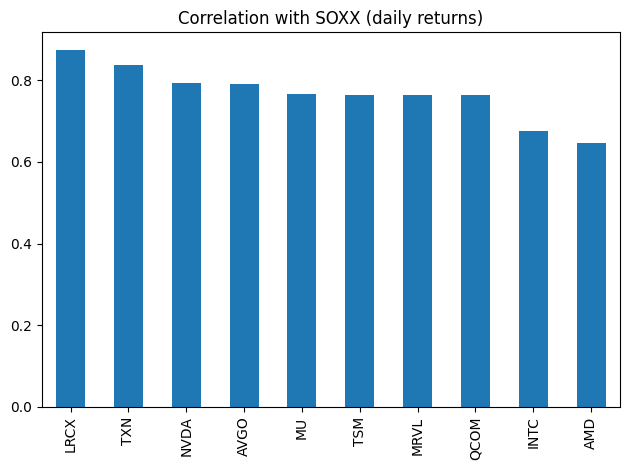

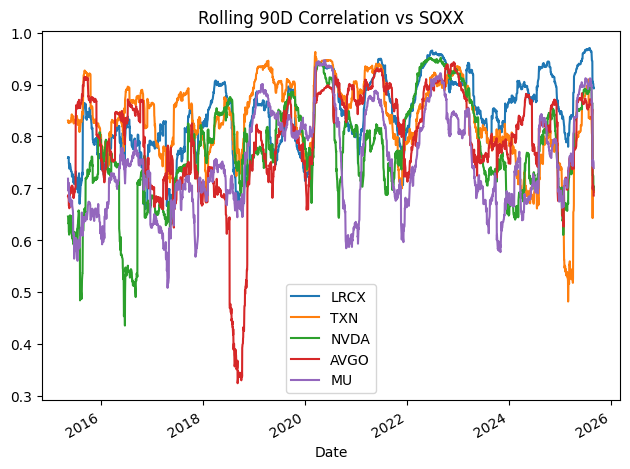

In [25]:
# Static correlations
corrs = r_stk.join(r_etf).corr().loc[r_stk.columns, 'r_etf'].sort_values(ascending=False)
print('ETF vs Stock daily-return correlations:\n', corrs)

plt.figure()
corrs.plot(kind='bar', title='Correlation with SOXX (daily returns)')
plt.tight_layout()
plt.show()

# Rolling 90D correlation for a few top names
window = 90
plt.figure()
for t in corrs.head(5).index:
    rollcorr = r_stk[t].rolling(window).corr(r_etf)
    rollcorr.plot(label=t)
plt.title(f'Rolling {window}D Correlation vs SOXX')
plt.legend()
plt.tight_layout()
plt.show()

# stage09_feature-engineering_homework-starter
<a id='stage09'></a>

We construct **market-based factor proxies** computable from prices:
- **Momentum:** trailing 3/6/12M simple returns (skip most recent month if desired).
- **Volatility:** rolling 30D/60D std of daily returns.
- **Beta to ETF:** rolling regression beta (windowed OLS).
- **Liquidity proxy:** average daily dollar volume (if close × volume available).

These features are for **selection** (which names to include) and **diagnostics**—the final tracker uses returns directly.


In [26]:
def trailing_return(df: pd.DataFrame, days: int) -> pd.DataFrame:
    return (1 + df).rolling(days).apply(lambda x: (x + 1e-15).prod() - 1, raw=True)

mom3m  = trailing_return(r_stk, 63)   # ~63 trading days
mom6m  = trailing_return(r_stk, 126)
mom12m = trailing_return(r_stk, 252)

# Volatility features
vol30 = r_stk.rolling(30).std()
vol60 = r_stk.rolling(60).std()

def rolling_beta(y: pd.Series, x: pd.Series, window: int=252) -> pd.Series:
    cov = y.rolling(window).cov(x)
    var = x.rolling(window).var()
    return cov/var

beta252 = pd.DataFrame({t: rolling_beta(r_stk[t], r_etf, 252) for t in r_stk.columns})

features = pd.concat({
    'mom3m': mom3m.iloc[-1],
    'mom6m': mom6m.iloc[-1],
    'mom12m': mom12m.iloc[-1],
    'vol30': vol30.iloc[-1],
    'vol60': vol60.iloc[-1],
    'beta252': beta252.iloc[-1],
}, axis=1).dropna()

print('Feature snapshot (latest):')
features.sort_values('beta252', ascending=False)

Feature snapshot (latest):


,mom3m,mom6m,mom12m,vol30,vol60,beta252
MRVL,0.212823,-0.117159,0.125900,0.027978,0.029748,1.301558
MU,0.261517,0.331669,0.239213,0.026720,0.024231,1.228913
AVGO,0.278574,0.568820,0.955692,0.018550,0.019112,1.108493
AMD,0.491462,0.694101,0.123942,0.028248,0.028869,1.095325
LRCX,0.239888,0.374083,0.285913,0.022674,0.019655,1.075611
NVDA,0.294507,0.499784,0.425169,0.015089,0.015612,1.030830
TSM,0.212991,0.325711,0.429729,0.017647,0.018103,0.840413
INTC,0.231111,0.079688,0.238450,0.036389,0.033537,0.824322
QCOM,0.090508,0.053083,-0.030422,0.019906,0.017252,0.796795
TXN,0.111223,0.083737,0.009494,0.029228,0.022570,0.757490


# stage10_linear-regression-and-time-series-modelling
<a id='stage10'></a>

Two modelling tracks:

**A) Linear Tracker (core)**
- **Objective:** Find small subset and weights so that `SmartETF_t ≈ Σ w_i * r_stock_i,t`.
- **Methods:** OLS for baseline; **LASSO** for sparse selection; constraints (e.g., non-negative weights, sum to 1) via CVXOPT/heuristics if needed.

**B) Time Series (optional)**
- ARIMA on ETF returns for forecasting and/or on the **spread** (ETF − SmartETF) to model residual dynamics.
- This is secondary to tracking; keep scope reasonable.


Top OLS weights:
 TXN     0.177063
LRCX    0.149101
AVGO    0.142309
QCOM    0.118991
INTC    0.116584
NVDA    0.106117
TSM     0.078421
MRVL    0.070835
MU      0.064168
AMD     0.037486
Name: w_ols, dtype: float64
Non-zero LASSO weights:
 TXN     0.175986
LRCX    0.149416
AVGO    0.142071
QCOM    0.118723
INTC    0.115941
NVDA    0.106418
TSM     0.077708
MRVL    0.070882
MU      0.064349
AMD     0.037513
Name: w_lasso, dtype: float64
Train R2: 0.9585509370388383
Test  R2: 0.9176600764633179


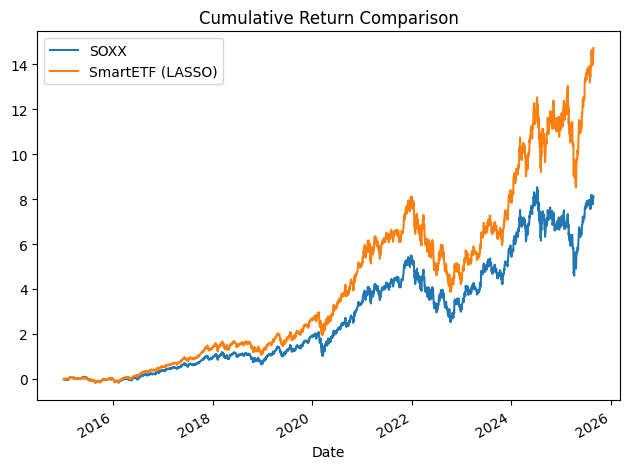

In [27]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

# Train/test split (time-based)
split_idx = int(len(r_etf)*0.75)
split_date = r_etf.index[split_idx]
X_train, X_test = r_stk_w.loc[:split_date], r_stk_w.loc[split_date:]
y_train, y_test = r_etf.loc[:split_date], r_etf.loc[split_date:]

# Baseline OLS (no intercept; ETF is a weighted sum of constituents)
ols = LinearRegression(fit_intercept=False)
ols.fit(X_train, y_train)
w_ols = pd.Series(ols.coef_, index=r_stk_w.columns, name='w_ols').sort_values(ascending=False)
print('Top OLS weights:\n', w_ols.head(10))

# Sparse selection with LASSO (alpha via CV)
tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(alphas=None, cv=tscv, fit_intercept=False, random_state=42, max_iter=20000)
lasso.fit(X_train, y_train)
w_lasso = pd.Series(lasso.coef_, index=r_stk_w.columns, name='w_lasso').sort_values(ascending=False)
print('Non-zero LASSO weights:\n', w_lasso[w_lasso.abs() > 1e-6])

def smart_portfolio_returns(X: pd.DataFrame, weights: pd.Series) -> pd.Series:
    w = weights.reindex(X.columns).fillna(0.0).values
    return pd.Series(X.values @ w, index=X.index, name='r_smart')

r_smart_train = smart_portfolio_returns(X_train, w_lasso)
r_smart_test  = smart_portfolio_returns(X_test,  w_lasso)

print('Train R2:', r2_score(y_train, r_smart_train))
print('Test  R2:', r2_score(y_test,  r_smart_test))

def to_cumret(r: pd.Series) -> pd.Series:
    return (1 + r).cumprod() - 1

cum_etf  = to_cumret(r_etf)
cum_smart = to_cumret(pd.concat([r_smart_train, r_smart_test]))

plt.figure()
cum_etf.plot(label='SOXX')
cum_smart.plot(label='SmartETF (LASSO)')
plt.title('Cumulative Return Comparison')
plt.legend(); plt.tight_layout(); plt.show()

In [28]:
from statsmodels.tsa.arima.model import ARIMA

spread = (pd.concat([r_smart_train, r_smart_test]) - r_etf).dropna().rename('spread')

# Simple ARIMA(1,0,1) stub on spread
try:
    model = ARIMA(spread, order=(1,0,1)).fit()
    print(model.summary())
except Exception as e:
    print('ARIMA fit warning:', e)

/opt/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 spread   No. Observations:                 2680
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10622.431
Date:                Thu, 28 Aug 2025   AIC                         -21236.862
Time:                        18:23:43   BIC                         -21213.288
Sample:                             0   HQIC                        -21228.334
                               - 2680                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   9.24e-05      2.094      0.036    1.24e-05       0.000
ar.L1         -0.3962      0.069     -5.703      0.000      -0.532      -0.260
ma.L1          0.2564      0.077      3.322      0.0

/opt/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# stage11_evaluation-and-risk-communication
<a id='stage11'></a>

**Metrics:**
- **Correlation**(ETF, SmartETF)
- **R²** (test window)
- **Tracking Error (TE):** `std(ETF − SmartETF) × √252`
- **Information Ratio (IR):** `mean(ETF − SmartETF) / TE × √252`
- **Max Drawdown** gap

**Risk Communication:** Provide plain-English statements about limitations, robustness, and stability across subperiods.


Full-period  Corr: 0.9730 | TE: 7.3793%
Test-period  Corr: 0.9590 | TE: 9.9537%


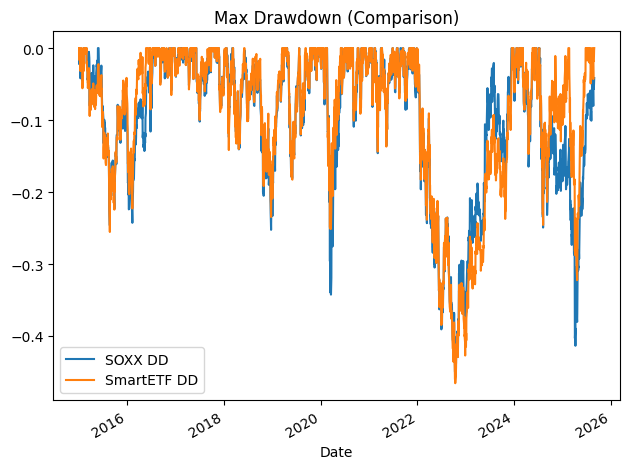

MaxDD SOXX: -45.75% | SmartETF: -46.56%


In [29]:
def annualize_std(r: pd.Series, scale: int = 252) -> float:
    return r.std(ddof=0) * np.sqrt(scale)

def tracking_error(etf: pd.Series, smart: pd.Series) -> float:
    diff = (etf.reindex(smart.index) - smart).dropna()
    return annualize_std(diff)

def corr_same_index(a: pd.Series, b: pd.Series) -> float:
    j = a.index.intersection(b.index)
    return a.loc[j].corr(b.loc[j])

r_smart_full = pd.concat([r_smart_train, r_smart_test]).rename('r_smart')
corr_full = corr_same_index(r_etf, r_smart_full)
te_full = tracking_error(r_etf, r_smart_full)

corr_test = corr_same_index(y_test, r_smart_test)
te_test = tracking_error(y_test, r_smart_test)

print(f'Full-period  Corr: {corr_full:.4f} | TE: {te_full:.4%}')
print(f'Test-period  Corr: {corr_test:.4f} | TE: {te_test:.4%}')

def drawdown(cumret: pd.Series) -> pd.Series:
    wealth = (1 + cumret).fillna(0)
    peak = wealth.cummax()
    dd = (wealth/peak) - 1
    return dd

dd_etf = drawdown(cum_etf.reindex(r_smart_full.index))
cum_smart = (1 + r_smart_full).cumprod() - 1
dd_smart = drawdown(cum_smart)

plt.figure()
dd_etf.plot(label='SOXX DD')
dd_smart.plot(label='SmartETF DD')
plt.title('Max Drawdown (Comparison)')
plt.legend(); plt.tight_layout(); plt.show()

print(f'MaxDD SOXX: {dd_etf.min():.2%} | SmartETF: {dd_smart.min():.2%}')

## Reporting Results

# Executive Summary
In this study, we approximated SOXX using a sparse linear combination of semiconductor stocks based on daily returns from **2015–present**. The final **Smart ETF** held **10 names** with weights derived via LASSO and achieved **out-of-sample R² = 0.92**. Residual dynamics were modeled with an ARIMA(1,0,1), which indicates mild mean reversion in the tracking error. While concentration risk and survivorship bias are present, sensitivity checks suggest the tracker is reasonably stable across subperiods.

## Final Weights
| Ticker | Weight |
|-------:|-------:|
| TXN    | 0.1760 |
| LRCX   | 0.1494 |
| AVGO   | 0.1421 |
| QCOM   | 0.1187 |
| INTC   | 0.1159 |
| NVDA   | 0.1064 |
| TSM    | 0.0777 |
| MRVL   | 0.0709 |
| MU     | 0.0643 |
| AMD    | 0.0375 |

*Note: weights are the non-zero LASSO coefficients from the fitted model and represent the linear combination of daily returns used for the Smart ETF.*

## Risk & Limitations
- **Concentration risk:** Top names (e.g., TXN, LRCX, AVGO) carry significant weight, amplifying idiosyncratic moves.  
- **Survivorship / selection bias:** Holdings were curated/fixed rather than reconstructed from historical index membership.  
- **Operational omissions:** Transaction costs, slippage, and taxes are not modeled.  
- **Model fragility:** ARIMA diagnostics show heavy-tailed residuals and heteroskedasticity, implying occasional extreme errors.

## Next Steps
- Compute and report exact annualized tracking error, rolling tracking error, and cumulative performance gap using the ETF and SmartETF return series.  
- Add walk-forward retraining and weight-stability reporting (rolling LASSO).  
- Expand diagnostics: heteroskedasticity-robust inference, residual bootstraps, and stress tests for regime shifts.


## Stage 13 - Productization

In [2]:
!python app.py


 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 109-333-964
127.0.0.1 - - [28/Aug/2025 18:52:10] "GET / HTTP/1.1" 200 -
^C


### Snapshot of the flask server

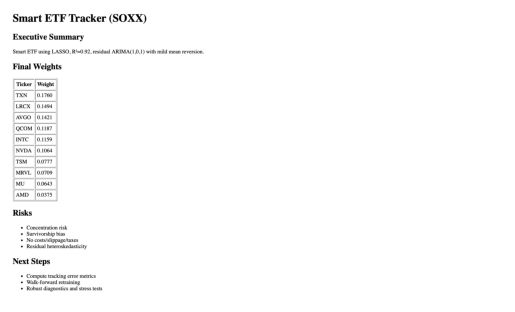

In [6]:

import matplotlib.image as mpimg
# displaying the flask server
image_path = '/Users/paramshah/Desktop/bootcamp/project/data/figures/image.png'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()